In [39]:
#################### IMPORTS ####################
import requests
import pandas as pd
from timezonefinder import TimezoneFinder
from sqlalchemy import create_engine, Table, Column, String, MetaData, Double
from sqlalchemy.dialects.mysql import insert
from datetime import datetime, timedelta
import cryptography

################### FUNCTIONS ###################
# insert_on_duplicate function found on
# "https://stackoverflow.com/questions/30337394/pandas-to-sql-fails-on-duplicate-primary-key"
def insert_on_duplicate(table, conn, keys, data_iter):
    """Execute SQL statement inserting data while ignoring duplicate values

    Args:
        table (pd.SQLTable): Table to save in database
        conn (sqlalchemy.engine): Engine that connects to the database
        keys (list): Names of the columns
        data_iter (iterable): Iterable that iterates the values to be inserted
    """
    insert_stmt = insert(table.table).values(list(data_iter))
    on_duplicate_key_stmt = insert_stmt.on_duplicate_key_update(insert_stmt.inserted)
    conn.execute(on_duplicate_key_stmt)

def get_api_data(api_url, parameters={}):
    """Function that downloads the data from an 
    endpoint, in this case the National Weather Service.
    This uses the requests module for python.

    Args:
        api_url (string): URL of the endpoint

    Returns:
        json: json with the downloaded data
    """

    api_url = "https://api.weather.gov/stations/044PG/observations"
    response = requests.get(api_url, params=parameters)
    weather_data = response.json()['features']
    
    return weather_data

def get_location(data):
    """Get longitude and latitude of the station data

    Args:
        data (array): Array of dictionaries with each observation of
        the weather station.

    Returns:
        tuple: Longitude (lon) and latitude (lat) of the weather station.
    """

    # Get coordinates for each dictionary of the data list.
    coordinates = list(map(lambda x: x['geometry']['coordinates'], data))

    # I know the timezone will be the same for all of the
    # observations as they are made by the same station,
    # but I still verified it by using the line below:
    # >>> all(x==coordinates[0] for x in coordinates)

    # If this was not the case, then a different function could be made
    # so that the code would iterate over the different stations
    # data, passing their data arrays one by one onto this function.

    # Extract the first element of the locations
    lon, lat = coordinates[0]

    return lon, lat

def get_timezone(lon, lat):
    """Get the timezone of the location

    Args:
        lon (float): Longitude of the location
        lat (float): Latitude of the location

    Returns:
        string: Timezone of the given location.
    """
    
    # Give the Latitude and Longitude 
    # as parameters to the timezone_at method
    # of a TimezoneFinder object.
    obj = TimezoneFinder() 

    # This returns the timezone of the specified
    # location
    result = obj.timezone_at(lng=lon, lat=lat)

    return result

def data_transformation(df, variables_to_extract):
    """Extract the values and related quantities
    of the variables in variables_to_extract.

    Args:
        df (dataframe): Dataframe with the 
        variables_to_extract (array): Array with the variables that we wish to extract
    """

    # This is used because the relevant variables
    # (temperature, windSpeed, relativehumidity) are
    # in nested columns with another values of interest.

    # For '{variable}_unit" I only extract the {unit} and not the {namespace}, 
    # see Personal Annotations!wmoUnit

    for variable in variables_to_extract:
        # The presence of each value is verified in case one of them is not present in the future.
        data_schema = df[f'{variable}'].values[0].keys()
        if 'unitCode' in data_schema: 
            df[f'{variable}_unit'] = df[f'{variable}'].apply(lambda x: x['unitCode'].split(':')[-1])
        if 'qualityControl' in data_schema:
            df[f'{variable}_qualityControl'] = df[f'{variable}'].apply(lambda x: x['qualityControl'])
        if 'value' in data_schema:
            # The values are rounded to two decimal points
            df[f'{variable}'] = df[f'{variable}'].apply(lambda x: x['value']).round(2)

def save_in_database(df, user, password, host, dbname):
    """Loads the data of a pandas dataframe into the
    previously created database

    Args:
        df (database): Database with the data that will be saved.
        user (string): Username to access the database
        password (string): Password to access the database
        host (string): Where the database is hosted
        dbname (string): Name of the database
    """

    # As per the documentation of SQLAlchemy:
    # The string form of the URL is 
    # dialect[+driver]://user:password@host/dbname[?key=value..]
    
    # In this case, I will use mysql and the pymysql as I have them installed in my computer
    engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{dbname}")

    # Create table with 'id' as primary key to avoid inserting duplicate values
    meta = MetaData()
    weather = Table(
        'weather', meta, 
        Column('id', String(255), primary_key = True),
        Column('relativeHumidity', Double),
        Column('relativeHumidity_qualityControl', String(1)),
        Column('relativeHumidity_unit', String(10)),
        Column('station', String(10)),
        Column('temperature', Double),
        Column('temperature_qualityControl', String(1)),
        Column('temperature_unit', String(10)),
        Column('timestamp', String(50)),
        Column('timezone', String(50)),
        Column('windSpeed', Double),
        Column('windSpeed_qualityControl', String(1)),
        Column('windSpeed_unit', String(10))
    )
    meta.create_all(engine)

    # if_exists='append' inserts values to existing table. 
    df.to_sql('weather', con=engine, if_exists='append', index=False, chunksize=4096, method=insert_on_duplicate)

################### MAIN FLOW ###################
# Extract data for the last 7 days from the API.
weather_data = get_api_data(
    "https://api.weather.gov/stations/044PG/observations", 
    {'start': (datetime.now() + timedelta(days=-7)).strftime("%Y-%m-%dT%H:%M:%SZ")}
)

# Initialize pandas dataframe with relevant data.
df_weather = pd.DataFrame(pd.DataFrame(weather_data)['properties'].to_list())
df_weather = df_weather[['@id', 'station', 'timestamp', 'temperature', 'windSpeed', 'relativeHumidity']].rename(columns={'@id': 'id'})

# Discard URL format of the station name
df_weather['station'] = df_weather['station'].apply(lambda x: x.split('/')[-1])

# Create timezone column with the timezone obtained
# by the location of the weather station.
lon, lat = get_location(weather_data)
df_weather['timezone'] = get_timezone(lon, lat)

# Transform data for the three
# needed variables: windSpeed, relativeHumidity
# and temperature.
data_transformation(
    df_weather, 
    ['windSpeed', 'relativeHumidity', 'temperature']
)

# Save the data in the previously created database: weather_front.
save_in_database(
    df_weather.dropna(subset=['id']), 
    user='front', 
    password='1234', 
    host='localhost', 
    dbname='weather_front'
)

# Personal annotations:

## Quality control:

### Level 1:

The level 1 validity checks restrict each observation to falling within a TSP-specified set of tolerance limits.

\* TSP: Technical Service Publication

### Level 2:

The level 2 temporal consistency checks restrict the temporal rate of change of each observation to a set of (other) TSP-specified tolerance limits.

The level 2 internal consistency checks enforce reasonable, meteorological relationships among observations measured at a single station. For example, a dewpoint temperature observation must not exceed the temperature observation made at the same station. If it does, both the dewpoint and temperature observation are flagged as failing their internal consistency check. This also includes comparison to the same variable measured hours before.

The level 2 statistical spatial consistency check uses weekly QC statistics to mark observations as failed if they failed any QC check 75% of the time during the previous 7 days. These observations will continue to be marked as failed by this check until such time as the failure rate falls below 25% in the weekly statistics. This check is only performed on observation types that go through the level 3 spatial consistency check.

### Level 3

The level 3 spatial consistency (or "buddy") check is performed using an Optimal Interpolation (OI) technique developed by Belousov et al. (1968). At each observation location, the difference between the measured value and the value analyzed by OI is computed. If the magnitude of the difference is small, the observation agrees with its neighbors and is considered correct. If, however, the difference is large, either the observation being checked or one of the observations used in the analysis is bad. To determine which is the case, a reanalysis to the observation location is performed by eliminating one neighboring observation at a time. If successively eliminating each neighbor does not produce an analysis that agrees with the target observation (the observation being checked), the observation is flagged as bad. If eliminating one of the neighboring observations produces an analysis that agrees with the target observation, then the target observation is flagged as "good" and the neighbor is flagged as "suspect." Suspect observations are not used in subsequent OI analyses. The following figure illustrates the reanalysis procedure:

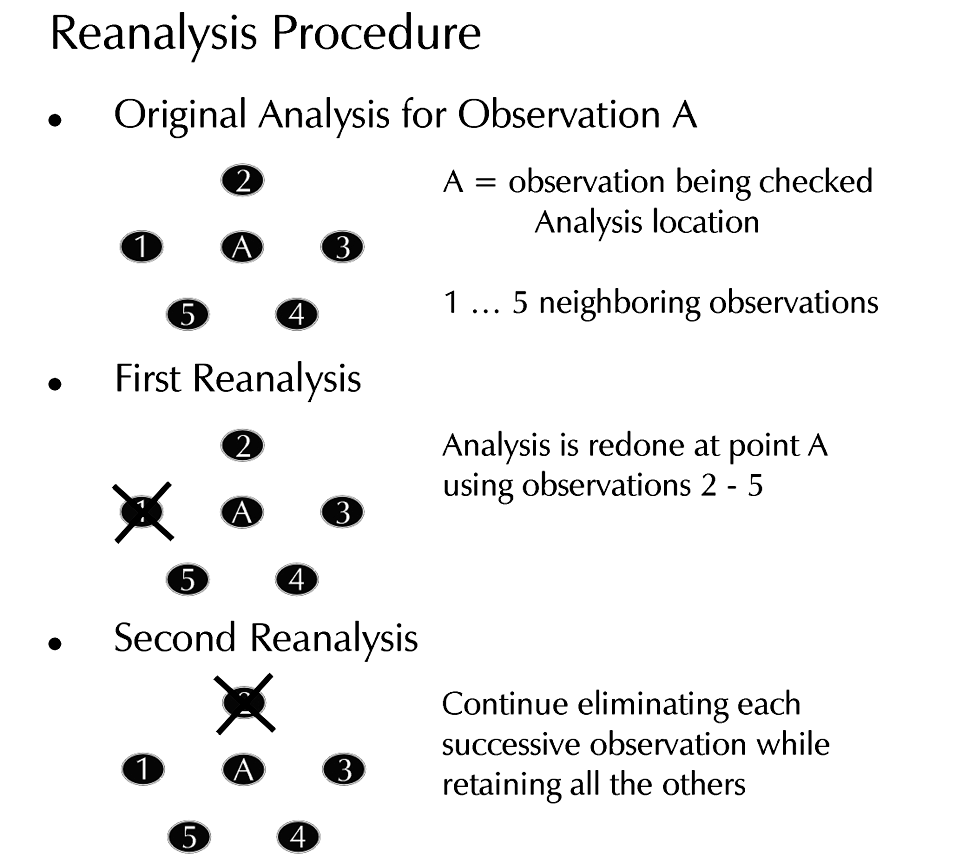

## wmoUnit

unitCode: A string denoting a unit of measure, expressed in the format "{unit}" or "{namespace}:{unit}". Units with the namespace "wmo" or "wmoUnit" are defined in the World Meteorological Organization Codes Registry at http://codes.wmo.int/common/unit and should be canonically resolvable to http://codes.wmo.int/common/unit/{unit}.

# SQL queries